In [1]:
import numpy as np
import pylab as pl

from pacholcsyk import *

To start with we can define a few parameters of the galaxy. 

- We'll model it as a solid disk with width 2kpc and a radius of 15kpc. 

- We'll assume a galactic magnetic field strength of 6 $\mu$G.

- We'll assume a thermal electron density of 0.01 cm$^{-3}$

- We'll assume a thermal electron temperature of $3\times 10^5$ K.

In [2]:
gal_radius_kpc = 15.
gal_height_kpc = 2.
H_G = 6e-6				# [G] = 6 uGauss  [CGS units]
H_T = H_G*1e-4          # T  [SI units]
ne_cm = 0.01			# cm^-3	[CGS units]
Te = 3e5				# [K]
N0 = 1e-10				# what should this be..? [m^-3 MeV^-1]

pc2cm = 3.086e18

In [3]:
nu = 10**np.arange(3,10,0.05)  # 1 kHz -> 10 GHz

In [4]:
em_nu = calc_em_synch(nu,H_G,N0)

integrals.py:15: RuntimeWarning: divide by zero encountered in log
  return quad(lambda x,*args: np.exp(x + np.log(func(np.exp(x),*args))), np.log(a), np.log(b), **kwargs)


In [5]:
kappa_nu = calc_kappa_synch(nu,H_G,N0)

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


In [6]:
dl = gal_radius_kpc*1000.*pc2cm
tau_nu = kappa_nu*dl

In [7]:
i_nu = (em_nu/kappa_nu)*(1 - np.exp(-1.*tau_nu))

We're going to compare with Longair's approximation. This is calculated in SI units:

In [8]:
dr = gal_radius_kpc*1000.*pc2cm/100. # metres [SI units]
A_m2 = np.pi*dr**2

L_abs = L_abs_ML(nu, H_T, A_m2)

Let's plot that up:

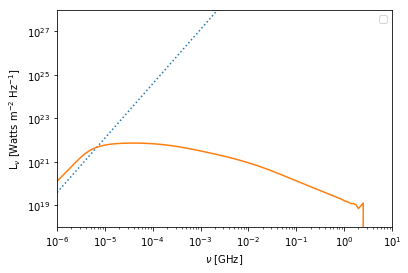

In [9]:
pl.subplot(111)
pl.plot(nu/1e9, L_abs, ls=":")
pl.plot(nu/1e9,i_nu*1e-3*4*np.pi*A_m2) 	# 1e-3 for conversion: erg/cm^2/Hz ---> Watts/m^2/Hz
pl.axis([10**-6,10,1e18,1e28])
pl.xlabel(r"$\nu$ [GHz]")
pl.ylabel(r"L$_{\nu}$ [Watts m$^{-2}$ Hz$^{-1}$]")
pl.legend()
pl.loglog()
pl.show()

To make the Fig 1(b) plot we need to loop:

In [ ]:
pl.subplot(111)

for i in range(0,7):
    
    N1 = N0*float(i)*100.
    em_nu = calc_em_synch(nu,H_G,N1)
    kappa_nu = calc_kappa_synch(nu,H_G,N1)
    tau_nu = kappa_nu*dl
    i_nu = (em_nu/kappa_nu)*(1 - np.exp(-1.*tau_nu))
    pl.plot(nu/1e9,i_nu*1e-3*4*np.pi*A_m2) 	# 1e-3 for conversion: erg/cm^2/Hz ---> Watts/m^2/Hz

pl.plot(nu/1e9, L_abs, ls=":")
pl.axis([10**-6,10,1e18,1e28])
pl.xlabel(r"$\nu$ [GHz]")
pl.ylabel(r"L$_{\nu}$ [Watts m$^{-2}$ Hz$^{-1}$]")
pl.legend()
pl.loglog()
pl.show()

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in divide
  if __name__ == '__main__':
